# PROJECT|| Recommendation Systems

### Build your own recommendation system for products on an e-commerce website like Amazon.com.
Dataset Link -
https://drive.google.com/file/d/1ClBptsK3V5KgKXtK2GSRzFNAW7GnTPDW/view?usp=sharing

Dataset columns - first three columns are userId, productId, and ratings and the fourth column is
timestamp. You can discard the timestamp column as in this case you may not need to use it.
Source - Amazon Reviews data (http://jmcauley.ucsd.edu/data/amazon/) The repository has
several datasets. For this case study, we are using the Electronics dataset.

Please Note -

● If you are facing any memory issue while working on this project, create a small subset (Let’s
say 10% of data) and work on it.

● If you are stuck at the model evaluation part of this project

If you are stuck at the model evaluation part of this project.
Please refer to below links -

1. https://surprise.readthedocs.io/en/stable/accuracy.html
    
2. http://surpriselib.com/ - 

Example :

<img src="Error_Metrics.png">

Start Building Reccomendation System :

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from surprise import KNNWithMeans
from surprise import accuracy
from surprise import SVD
import recmetrics
from surprise import Reader, Dataset
from surprise.model_selection import train_test_split

In [2]:
import os
os.chdir('G:\Residency6\PROJECT\Recommendation_Systems_Project')

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Step 1:Read and explore the given dataset. ( Rename column/add headers, plot histograms,find data characteristics)

In [60]:
# Reading the dataset and providing header(column names).
df = pd.read_csv('G:\Residency6\PROJECT\Recommendation_Systems_Project\Sample.csv',
                       names=['userId','productId','ratings','timestamp'])

In [61]:
df.head(5)

,userId,productId,ratings,timestamp
0,AKM1MP6P0OYPR,132793040,5,1365811200
1,A2CX7LUOHB2NDG,321732944,5,1341100800
2,A2NWSAGRHCP8N5,439886341,1,1367193600
3,A2WNBOD3WNDNKT,439886341,3,1374451200
4,A1GI0U4ZRJA8WN,439886341,1,1334707200


In [62]:
df.shape

(1042800, 4)

In [63]:
df['userId'].nunique()

782281

In [64]:
df['productId'].nunique()

61764

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1042800 entries, 0 to 1042799
Data columns (total 4 columns):
userId       1042800 non-null object
productId    1042800 non-null object
ratings      1042800 non-null int64
timestamp    1042800 non-null int64
dtypes: int64(2), object(2)
memory usage: 31.8+ MB


In [66]:
df.drop_duplicates(keep='first',inplace=True)

In [67]:
df.shape

(1042800, 4)

In [68]:
#dropping timestamp column - it's of no significance 
df = df.drop(labels = "timestamp", axis = 1)

In [69]:
df.shape

(1042800, 3)

In [70]:
#Type Conversion
#df['userId'] = df['userId'].astype('category')
#df['productId'] = df['productId'].astype('category')

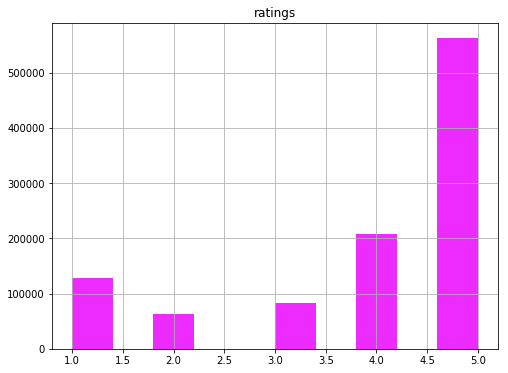

In [71]:
df.hist(figsize=(8,6), xlabelsize = 10);

More than 50% percent of the population has given ratings between 4.6 and 5.


In [72]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ratings,1042800.0,3.971919,1.400337,1.0,3.0,5.0,5.0,5.0


In [73]:
#sns.set(style="darkgrid")
#sns.countplot(df['userId'],hue=df['ratings'])

In [74]:
#sns.countplot(df['productId'],hue=df['ratings'])

## 2. Take a subset of the dataset to make it less sparse/ denser. ( For example, keep the users only who has given 50 or more number of ratings )

Filtering users who have rated atleast 50 products

In [75]:
from collections import Counter
counts = Counter(df.userId)
df_popular = df[df.userId.isin([key for key in counts if counts[key] > 49])]
df_popular[df_popular.userId.isin([key for key in counts if counts[key] > 49])].count()

userId       3400
productId    3400
ratings      3400
dtype: int64

In [76]:
df_popular.shape

(3400, 3)

So now in our dataset we only have users who rated atleast 50 products or more.

## 3. Build Popularity Recommender model.

In [21]:
# These many product must be displayed after groupby
df_popular['productId'].nunique()

2902

In [22]:
df_popular['userId'].nunique()

37

In [23]:
df_popular.head(2)

,userId,productId,ratings
2162,A5JLAU2ARJ0BO,1400532655,1
3050,ALUNVOQRXOZIA,1400599997,1


Finding the highest average rated product.

In [24]:
ratings_mean_count = pd.DataFrame(df_popular.groupby('productId')['ratings'].mean()) 

In [25]:
ratings_mean_count['ratings'].sort_values(ascending=False).head(10)

productId
B0001EY1GY    5.0
B00004ZCCT    5.0
B0000AGAWV    5.0
B0000AGAXZ    5.0
B0000AGAZ8    5.0
B00004ZCEX    5.0
B00004ZCDD    5.0
B0000AHO2T    5.0
B0000AINEH    5.0
B0000AJ3MV    5.0
Name: ratings, dtype: float64

Above products are the most popular products

In [26]:
# Creating a column in the dataframse to records the number of times a product is rated.
ratings_mean_count['rating_counts'] = pd.DataFrame(df_popular.groupby('productId')['ratings'].count())  

In [27]:
ratings_mean_count.sort_values(by=['ratings','rating_counts'],ascending=False).head(5)

,ratings,rating_counts
productId,,
B0007QKMQY,5.0,4
B000BY52NK,5.0,4
B00004Z5M1,5.0,3
B000050AQ7,5.0,3
B00005LENO,5.0,3


Above is the product Ids sorted based on the ratings and times rated.

In [28]:
#Check the shape of new dataframe in which rows must be equal to df_popular['productId'].nunique().
ratings_mean_count.shape

(2902, 2)

## 4. Split the data randomly into train and test dataset. ( For example, split it in 70/30 ratio)


In [29]:
reader = Reader()
df_UserUser = Dataset.load_from_df(df_popular[['userId', 'productId', 'ratings']], reader)
test_size = 0.30
trainset,testset = train_test_split(df_UserUser,test_size=test_size)

## 5. Build Collaborative Filtering model.

## Single Value Decomposition

In [46]:
#train SVD recommender
algo = SVD()
algo.fit(trainset)

#make predictions on test set. 
test = algo.test(testset)
test = pd.DataFrame(test)
test.drop("details", inplace=True, axis=1)
test.columns = ['uid', 'pid', 'r_ui', 'est']
test.head()


,uid,pid,r_ui,est
0,A5JLAU2ARJ0BO,B0000658CG,5.0,3.302493
1,AKT8TGIT6VVZ5,B0001GGXK4,4.0,4.723499
2,A12DLJESJKM1OQ,B00006FMPE,5.0,4.215099
3,AGXV8E7XK9J6H,B00007GQLU,5.0,4.130844
4,A12DLJESJKM1OQ,B00005ABEH,3.0,4.351956


In [47]:
#create model (matrix of predicted values)
cf_model = test.pivot_table(index='uid', columns='pid', values='est').fillna(0)

### USER- USER

In [32]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
algo = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': True})
algo.fit(trainset)

# run the trained model against the testset
test_pred_User = algo.test(testset)
test_pred_User

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


[Prediction(uid='A5JLAU2ARJ0BO', iid='B0000658CG', r_ui=5.0, est=3.823321554770318, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='AKT8TGIT6VVZ5', iid='B0001GGXK4', r_ui=4.0, est=4.23109243697479, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A12DLJESJKM1OQ', iid='B00006FMPE', r_ui=5.0, est=3.987629886194953, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='AGXV8E7XK9J6H', iid='B00007GQLU', r_ui=5.0, est=4.162790697674419, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A12DLJESJKM1OQ', iid='B00005ABEH', r_ui=3.0, est=4.23109243697479, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='AT6CZDCP4TRGA', iid='B00019VAWC', r_ui=3.0, est=4.23109243697479, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A2R6RA8FRBS608', iid='B00004SU73', r_ui=4.0, est=4.23109243697479, details={'was_impossible': True,

## ITEM - ITEM

In [33]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
algo_Item = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo_Item.fit(trainset)

# run the trained model against the testset
test_pred_Item = algo_Item.test(testset)
test_pred_Item

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


[Prediction(uid='A5JLAU2ARJ0BO', iid='B0000658CG', r_ui=5.0, est=5, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='AKT8TGIT6VVZ5', iid='B0001GGXK4', r_ui=4.0, est=4.23109243697479, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A12DLJESJKM1OQ', iid='B00006FMPE', r_ui=5.0, est=3.0, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='AGXV8E7XK9J6H', iid='B00007GQLU', r_ui=5.0, est=4.0, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A12DLJESJKM1OQ', iid='B00005ABEH', r_ui=3.0, est=4.23109243697479, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='AT6CZDCP4TRGA', iid='B00019VAWC', r_ui=3.0, est=4.23109243697479, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A2R6RA8FRBS608', iid='B00004SU73', r_ui=4.0, est=4.23109243697479, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),


## 6.Evaluate the above model.

##### SVD model

In [34]:
# USING SVD
#evaluate model with MSE and RMSE
print ('User-User CF MSE : ',recmetrics.mse(test.r_ui, test.est))
print ('User-User CF RMSE : ',recmetrics.rmse(test.r_ui, test.est))

User-User CF MSE :  1.1517917128875268
User-User CF RMSE :  1.0732155947839777


##### USER-USER

In [35]:
# get RMSE
print("User-based Model : Test Set")
accuracy.rmse(test_pred_User, verbose=True)

User-based Model : Test Set
RMSE: 1.1594


1.1593514393070639

##### ITEM-ITEM 

In [36]:
# get RMSE
print("Item-based Model : Test Set")
accuracy.rmse(test_pred_Item, verbose=True)

Item-based Model : Test Set
RMSE: 1.2338


1.2337780901982434

# 7.Get top - K ( K = 5) recommendations. Since our goal is to recommend new products to each user based on his/her habits, we will recommend 5 new products.


##### SVD Recommendations

In [48]:
def get_users_predictions(user_id, n, model):
    recommended_items = pd.DataFrame(model.loc[user_id])
    recommended_items.columns = ["predicted_rating"]
    recommended_items = recommended_items.sort_values('predicted_rating', ascending=False)    
    recommended_items = recommended_items.head(n)
    return recommended_items.index.tolist()

In [49]:
#get example prediction
get_users_predictions('A6FIAB28IS79', 5, cf_model)

['B00006HCHH', 'B000ARSLB8', 'B000GHDPHC', 'B0002A6YVC', 'B00005N6KF']

In [50]:
#format test data
test = test.copy().groupby('uid')['pid'].agg({'actual': (lambda x: list(set(x)))})
#make recommendations for all members in the test data
recs = []
for user in test.index:
    SVD_predictions = get_users_predictions(user, 5, cf_model)
    recs.append(SVD_predictions)
        
test['SVD_reco'] = recs
test.head(10)

,actual,SVD_reco
uid,,
A11D1KHM7DVOQK,"[B0001G6UCA, B0007RB1X6, B00081PR72, B0009E5YN...","[B000FONSEQ, B00007EDM8, B00005QBUU, B000001OM..."
A12DLJESJKM1OQ,"[B000067VKY, B000068U1L, B000AYGDWU, B00005B9A...","[B000087LII, B0000DBJJT, B00008J639, B000087BX..."
A1435P5AMCPB3X,"[B00007IFEQ, B0000YKAB0, B00006JPKB, B000HSCLB...","[B000F3H9UG, B000COKR2K, B00007IFEQ, B00008Y1B..."
A149RNR5RH19YY,"[B0007IG23Y, B0009N5MDI, B0000BZO6E, B0001BRIT...","[B000AMLXHW, B00005B8HU, B0002DV9CS, B00005NBR..."
A15QYHQH80W30L,"[B0002GFORQ, B00009R8AF, B000CRUBAA, B00009UT1...","[B00007EDZG, B000EOSHGQ, B00005LEN4, B000BY52N..."
A1F9Z42CFF9IAY,"[B000ETY3LO, B00001WRSJ, B0001FTVE0, B00007E7Q...","[B0002LEMWE, B00009RUCH, B00006HCCK, B00006B7D..."
A1FR68QH6Z4YZM,"[B000FKKWVM, B0000AKVHF, B0000B35CK, B0000DYTD...","[B000BY52NK, B0000B35CK, B0007G6RZE, B00017LUR..."
A1JWSDDIH5Z7DV,"[B0007OW51Q, B0002KQR1Y, B0002ILKMW, B0007OW57...","[B0001XLS4S, B0007OW57K, B000COW90I, B00008WIX..."
A1MJMYLRTZ76ZX,"[B00006HYFE, B00065DGNC, B00008K4BD, B000E5CYS...","[B00005Y1Z6, B000021YU8, B00065DGNC, B00004ZCJ..."


##### Popularity Based - 

In [51]:
#make recommendations for all members in the test data
popularity_recs = df_popular.productId.value_counts().head(10).index.tolist()

recs = []
for user in test.index:
    pop_predictions = popularity_recs
    recs.append(pop_predictions)
        
test['Popularity_Reco'] = recs
test.head()

,actual,SVD_reco,Popularity_Reco
uid,,,
A11D1KHM7DVOQK,"[B0001G6UCA, B0007RB1X6, B00081PR72, B0009E5YN...","[B000FONSEQ, B00007EDM8, B00005QBUU, B000001OM...","[B00004SB92, B00004ZCJE, B000BKJZ9Q, B0009RKL5..."
A12DLJESJKM1OQ,"[B000067VKY, B000068U1L, B000AYGDWU, B00005B9A...","[B000087LII, B0000DBJJT, B00008J639, B000087BX...","[B00004SB92, B00004ZCJE, B000BKJZ9Q, B0009RKL5..."
A1435P5AMCPB3X,"[B00007IFEQ, B0000YKAB0, B00006JPKB, B000HSCLB...","[B000F3H9UG, B000COKR2K, B00007IFEQ, B00008Y1B...","[B00004SB92, B00004ZCJE, B000BKJZ9Q, B0009RKL5..."
A149RNR5RH19YY,"[B0007IG23Y, B0009N5MDI, B0000BZO6E, B0001BRIT...","[B000AMLXHW, B00005B8HU, B0002DV9CS, B00005NBR...","[B00004SB92, B00004ZCJE, B000BKJZ9Q, B0009RKL5..."
A15QYHQH80W30L,"[B0002GFORQ, B00009R8AF, B000CRUBAA, B00009UT1...","[B00007EDZG, B000EOSHGQ, B00005LEN4, B000BY52N...","[B00004SB92, B00004ZCJE, B000BKJZ9Q, B0009RKL5..."


Here is the recommendations for the users.

## 8. Summarise your insights.

Recall

In [52]:
actual = test.actual.values.tolist()
cf_predictions = test.SVD_reco.values.tolist()
pop_predictions = test.Popularity_Reco.values.tolist()

In [53]:
pop_mark = []
for K in np.arange(1, 11):
    pop_mark.extend([recmetrics.mark(actual, pop_predictions, k=K)])
pop_mark

[0.0013513513513513514,
 0.0023923923923923926,
 0.002635879122365609,
 0.002973716960203447,
 0.003043917030403517,
 0.0033979963318512395,
 0.0036929341267890347,
 0.003923633576238484,
 0.003923633576238484,
 0.0040362461888510965]

In [54]:
cf_mark = []
for K in np.arange(1, 11):
    cf_mark.extend([recmetrics.mark(actual, cf_predictions, k=K)])
cf_mark

[0.047598157215583116,
 0.09519631443116623,
 0.1427944716467494,
 0.19039262886233246,
 0.23799078607791563,
 0.23799078607791563,
 0.23799078607791563,
 0.23799078607791563,
 0.23799078607791563,
 0.23799078607791563]

Mark Plot

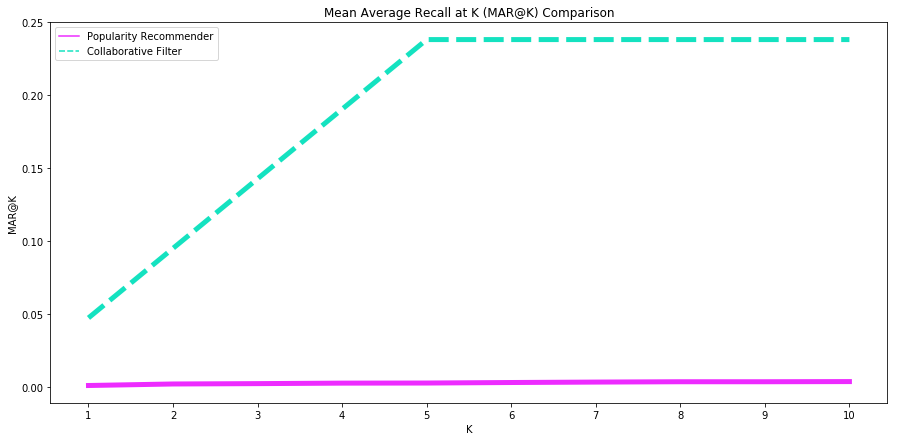

In [55]:
mark_scores = [pop_mark, cf_mark]
index = range(1,10+1)
names = ['Popularity Recommender', 'Collaborative Filter']

fig = plt.figure(figsize=(15, 7))
recmetrics.mark_plot(mark_scores, model_names=names, k_range=index)

#### Coverage

In [56]:
catalog = df_popular.productId.unique().tolist()
pop_coverage = recmetrics.coverage(pop_predictions, catalog)
cf_coverage = recmetrics.coverage(cf_predictions, catalog)

#### Coverage Plot

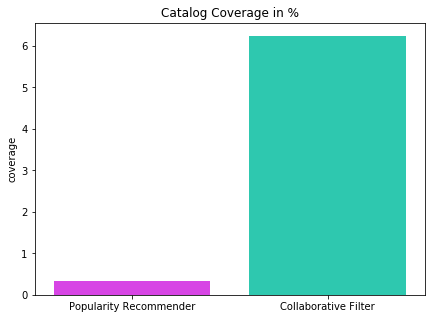

In [57]:
coverage_scores = [ pop_coverage, cf_coverage]
model_names = ['Popularity Recommender', 'Collaborative Filter']

fig = plt.figure(figsize=(7, 5))
recmetrics.coverage_plot(coverage_scores, model_names)

We are working on the sample of 1042800 ratings provided for the 61764 different products by 782281 different users.There 
are no missing values in the data.We have 4 columns out of which timestamp is not significant for predicting the new 
products for the exisisting or the new users hence we can drop it.For making the data less sparse we are selecting user who 
have provided atleast 50 ratings which reduced the data set to 3400 records(ratings) and three columns(UserID,ProductID,Ratings).
So, we checked for missing values(missing ratings,Id's),corrupted values(such as invalid entries).Now the data has - 
2092 - unique products
37 - unique users
                                  
Explored the data and performed in-depth analysis removed duplicates though there were no duplicates exsisting.
                                  

Designed the Popularity based RS - with this we the recommendation for the products to the new customers who has not provided any ratings till now can be effectively done.
But this is not personalized . Therefore, we created a Collaforatively filter model  using SVD algo -
To increase the sale through the existing customers by providing them new products suggestions to buy.
The algo worked on finding the similarity measure of the users with other users and recommend new products.                        

                                  


Conclusion :- 

This Recommendation System model implemented the strategies that can be employed for improving sales in AMAZON.